In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))
X_train, X_test = X_train/255, X_test/255

# Denoise Autoencoder

In [3]:
a = 0.5
X_train_noise = X_train + a * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise  = X_test  + a * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noise = np.clip(X_train_noise, 0.0, 1.0)
X_test_noise  = np.clip(X_test_noise, 0.0, 1.0)

In [6]:
from tensorflow.keras.layers import Layer, Input, Dense, LeakyReLU 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import UpSampling2D, Reshape
from tensorflow.keras.models import Model

inputs = Input(shape=(28, 28, 1))
encoded = Conv2D(8, kernel_size=3, strides=1, padding='same')(inputs)
encoded = LeakyReLU(0.01)(encoded)
encoded = Conv2D(16, kernel_size=3, strides=2, padding='same')(encoded)
encoded = LeakyReLU(0.01)(encoded)
encoded = Conv2D(32, kernel_size=3, strides=2, padding='same')(encoded)
encoded = LeakyReLU(0.01)(encoded)
encoded = Flatten()(encoded)
encoded = Dense(32)(encoded)
encoded = LeakyReLU(0.01)(encoded)

decoded = Dense(7*7*1)(encoded)
decoded = LeakyReLU(0.01)(decoded)
decoded = Reshape((7, 7, 1))(decoded)
decoded = Conv2D(32, kernel_size=3, strides=1, padding='same')(decoded)
decoded = LeakyReLU(0.01)(decoded)
decoded = UpSampling2D(size=(2, 2))(decoded)
decoded = Conv2D(16, kernel_size=3, strides=1, padding='same')(decoded)
decoded = LeakyReLU(0.01)(decoded)
decoded = UpSampling2D(size=(2, 2))(decoded)
decoded = Conv2D(8, kernel_size=3, strides=1, padding='same')(decoded)
decoded = LeakyReLU(0.01)(decoded)
decoded = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(decoded)

encoder = Model(inputs=inputs, outputs=encoded)
autoencoder = Model(inputs=inputs, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 28, 28, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 32)          0   

In [7]:
autoencoder.fit(X_train_noise, X_train, 
                epochs=100, batch_size=1024, 
                shuffle=True)

Epoch 1/100


2022-11-05 16:08:37.249927: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-05 16:08:37.472046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 56ms/step - loss: 0.4078
Epoch 2/100
59/59 [==============================] - 3s 53ms/step - loss: 0.2686
Epoch 3/100
59/59 [==============================] - 3s 54ms/step - loss: 0.2370
Epoch 4/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1980
Epoch 5/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1774
Epoch 6/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1684
Epoch 7/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1622
Epoch 8/100
59/59 [==============================] - 3s 53ms/step - loss: 0.1573
Epoch 9/100
59/59 [==============================] - 3s 53ms/step - loss: 0.1529
Epoch 10/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1494
Epoch 11/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1468
Epoch 12/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1444
Epoch 13/100
59/59 [=================

In [8]:
X1 = X_test[0:1, :]
N1 = X_test_noise[0:1, :]
Z1 = encoder.predict(N1)
R1 = autoencoder.predict(N1)

X2 = X_test[1:2, :]
N2 = X_test_noise[1:2, :]
Z2 = encoder.predict(N2)
R2 = autoencoder.predict(N2)

1/1 [==============================] - 0s 14ms/step


2022-11-05 16:14:57.653863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-05 16:14:57.732041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


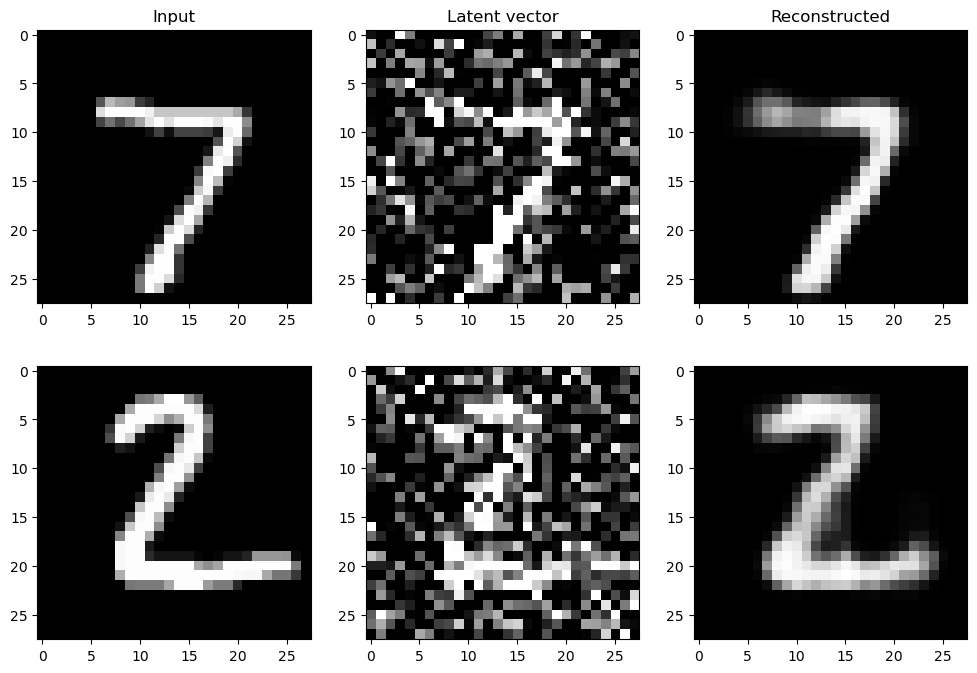

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), width_ratios=(1,1,1))
ax[0, 0].imshow(X1.reshape((28, 28)), cmap='gray')
ax[0, 1].imshow(N1.reshape((28, 28)), cmap='gray')
ax[0, 2].imshow(R1.reshape((28, 28)), cmap='gray')
ax[1, 0].imshow(X2.reshape((28, 28)), cmap='gray')
ax[1, 1].imshow(N2.reshape((28, 28)), cmap='gray')
ax[1, 2].imshow(R2.reshape((28, 28)), cmap='gray')

ax[0, 0].set_title('Input')
ax[0, 1].set_title('Latent vector')
ax[0, 2].set_title('Reconstructed')

# plt.show()
plt.savefig("mnist_denoise_autoencoder_output.pdf", bbox_inches='tight')

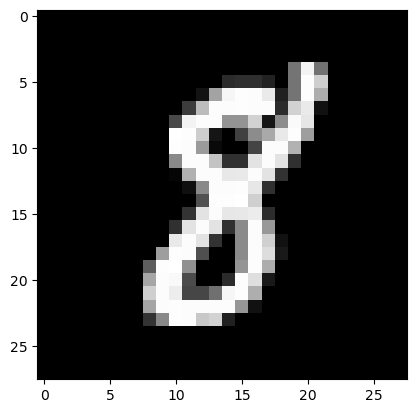

In [17]:
idx = 41
X = X_train[idx:(idx+1), :]
N = X_train_noise[idx:(idx+1), :]
Z = autoencoder(N)

plt.imshow(X.reshape((28, 28)), cmap='gray')
plt.savefig('x41_original.pdf', bbox_inches='tight')

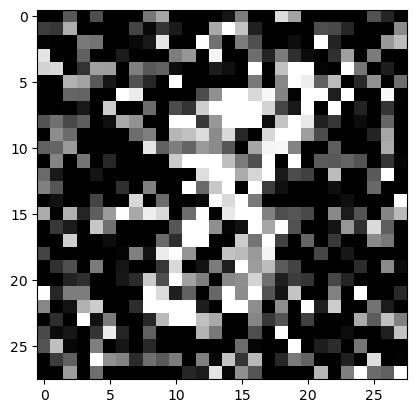

In [18]:
plt.imshow(N.reshape((28, 28)), cmap='gray')
plt.savefig('x41_noise.pdf', bbox_inches='tight')